## Data preparation

In [1]:
import numpy as np

labels = list()

with open('Cancerdata.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:
            continue
        line = line.split('\t')
        line = [item.rstrip() for item in line]
        line[0] = float(line[0].strip('"'))
        line[1:] = [float(x) for x in line[1:]]
        line = np.asarray(line)
        
        # Append labels
        labels.append(int(line[1]))
        
        # Create the data np.array with first observation
        # Vstack the rest of the observations to the newly created data matrix
        observation = line[2:]
        if i == 1:
            data = observation
        else:
            data = np.vstack((data, observation))
        
labels = np.asarray(labels)

print(np.shape(labels))
print(np.shape(data))

(82,)
(82, 2999)


### Plot functions

In [2]:
def plot_true_vs_predict_2d(true_labels, predicted_labels, pca_component1=None, pca_component2=None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2

    colors = ['red', '#7FFF00', 'blue']
    plt.figure(3)

    for i in u_labels:
        plt.scatter(principal_components_pca[predicted_labels == i , pca_component1] , principal_components_pca[predicted_labels == i , pca_component2] , label = i, color=colors[i])
        plt.scatter(principal_components_pca[true_labels == i , pca_component1] , principal_components_pca[true_labels == i , pca_component2] , label = i, marker="x", color=colors[i], zorder=5)

    plt.title('Plot of the real-label and kMean-label')
    plt.xlabel('Principal component ' + str(pca_component1+1))
    plt.ylabel('Principal component ' + str(pca_component2+1))

In [3]:
def plot_true_vs_predict_3d(true_labels, predicted_labels, pca_component1=None, pca_component2=None, pca_component3 = None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2
    pca_component3 = 2 if pca_component3 is None else pca_component3

    colors = ['red', '#7FFF00', 'blue']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection ='3d')


    for i in u_labels:
        plt.scatter(principal_components_pca[predicted_labels == i , pca_component1] , principal_components_pca[predicted_labels == i , pca_component2], principal_components_pca[predicted_labels == i , pca_component3] , label = i, color=colors[i])
        plt.scatter(principal_components_pca[true_labels == i , pca_component1] , principal_components_pca[true_labels == i , pca_component2], principal_components_pca[true_labels == i , pca_component3], label = i, marker="x", color=colors[i], zorder=5)

    plt.title('Plot of the real-label and kMean-label')
    plt.xlabel('Principal component ' + str(pca_component1+1))
    plt.ylabel('Principal component ' + str(pca_component2+1))

## Step 1

### Dimension and feature selection techniques suited for unsupervised clustering tasks

1. Principal Component Analysis (PCA)
2. Independent Component Analysis (ICA)
3. Random Projections
4. Feature Selection based on Clustering Quality
5. Recursive Feature Elimination (RFE)

Principal Component Analysis (PCA): PCA is a technique that reduces the dimensionality of the data by identifying the most important features that capture the most variance in the data. PCA is a powerful technique for feature selection, as it can often reduce the number of features required for clustering while still retaining the important information.

Independent Component Analysis (ICA): ICA is a technique that separates the data into independent sources based on statistical properties. ICA can be used for feature selection by identifying the features that have the most independent information, which can help to remove redundant or noisy features.

Random Projections: Random projections is a technique that can be used to reduce the dimensionality of the data by projecting the data onto a lower-dimensional subspace. Random projections can be used for feature selection by identifying the most important dimensions that capture the most variance in the data.

Feature Selection based on Clustering Quality: This approach selects the features that produce the best clustering results. This method works by selecting a subset of features and evaluating the clustering performance with different clustering algorithms, and selecting the subset of features that results in the best clustering performance.

Recursive Feature Elimination (RFE): RFE is a feature selection method that selects features by recursively considering smaller and smaller subsets of features. RFE works by training a model on the full set of features, ranking the importance of the features, and then eliminating the least important feature. This process is repeated until a predetermined number of features is reached.

## PCA

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


data_pp = StandardScaler().fit_transform(data)
pca = PCA(svd_solver="auto").fit(data_pp)
# The PCA object offers convenient ways of accessing the
# principal directions and explained variance
pca.components_;
pca.explained_variance_;

# To get the principal components, the `transform` method of the
# PCA object can be used
principal_components_pca = pca.transform(data_pp)

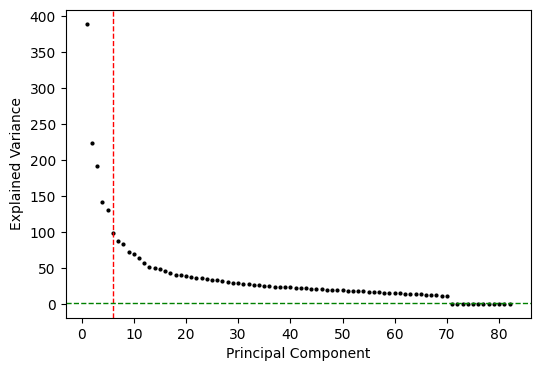

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.components_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(6, linestyle="dashed", color="red", linewidth=1)
ax.axhline(1, linestyle="dashed", color="green", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca(data, n_components):
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Fit PCA to the scaled data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_data)
    
    # Transform the data using the fitted PCA model
    principal_components = pca.transform(scaled_data)
    
    # Return the principal components and explained variance ratio
    return principal_components

### Random projection

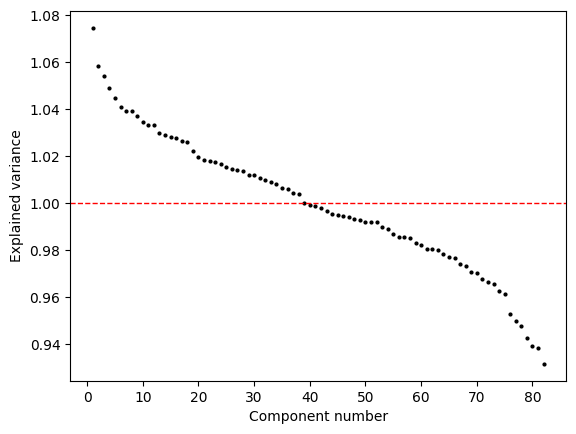

Number of components = 39


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=82).fit(data)

# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]# Compute the explained variance ratio for each component
explained_variances = np.abs(rp.components_).var(axis=1) / np.abs(rp.components_).var().sum()

# Sort the components based on their explained variance
sorted_indices = np.argsort(explained_variances)[::-1]
explained_variances_sorted = explained_variances[sorted_indices]

# Plot the scree plot
plt.plot(np.arange(1, len(explained_variances) + 1), explained_variances_sorted, 'ok',markersize=2)
plt.axhline(1, linestyle="dashed", color="red", linewidth=1)
plt.xlabel('Component number')
plt.ylabel('Explained variance')
plt.show()

n_components = np.sum(explained_variances_sorted > 1)
print(f'Number of components = {n_components}')

In [7]:
def random_projection(data, nr_components):
    scaled_data = StandardScaler().fit_transform(data)
    return GaussianRandomProjection(n_components=nr_components).fit_transform(scaled_data)
    

In [9]:
pred_label = crossval('kmeans',nr_clusters_list, nr_components_list)

0.21066171079101498
0.10832069480104022
0.08880683426987031
0.10293003392965971


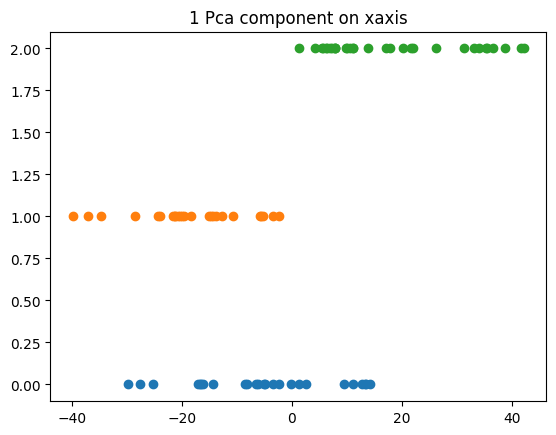

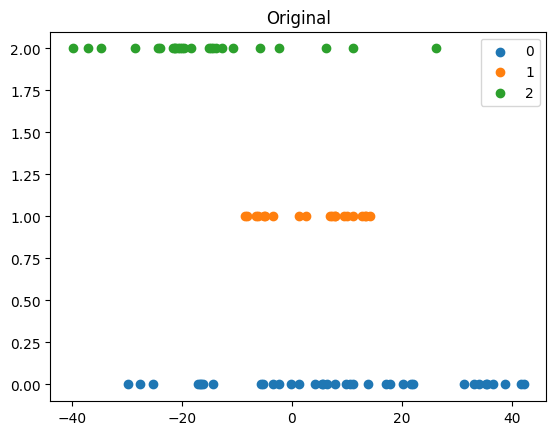

In [19]:
u_labels = np.unique(labels)
y_values = np.arange(len(u_labels))  # create an array of y-axis values for each cluster

for i, label in enumerate(u_labels):
    plt.figure(1)
    plt.title('1 Pca component on xaxis')
    plt.scatter(principal_components_pca[pred_label == label , 0], y_values[i]*np.ones(len(principal_components_pca[pred_label == label , 0])), label = label)
    plt.figure(2)
    plt.title('Original')
    plt.scatter(principal_components_pca[labels == label , 0] , y_values[i]*np.ones(len(principal_components_pca[labels == label , 0])), label = label)

plt.legend()
plt.show()


range(0, 32)


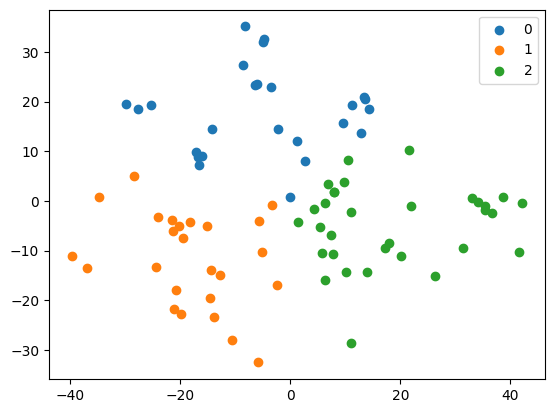

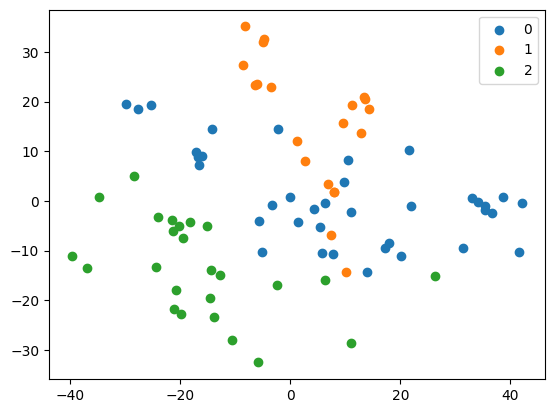

In [11]:
cluster = 3
reduced_data = pca(data, 2)
score, pred_label = kmeans_clustering_cvscore(reduced_data, cluster)

for i in u_labels:
    plt.figure(1)
    plt.scatter(reduced_data[pred_label == i , 0], reduced_data[pred_label == i , 1] , label = i)
    plt.legend()
    plt.figure(2)
    plt.scatter(reduced_data[labels == i , 0] , reduced_data[labels == i , 1] , label = i)

print(range(0,len(reduced_data[pred_label == i , 1])))
plt.legend()
plt.show()

In [26]:
nr_components_list = [5, 10, 20, 30]
nr_clusters_list = [1, 2, 3, 4, 5]
#Calinski-harbaz score
#Davies-Bouldin

def crossval(fun, nr_clusters_list, nr_components_list):
    for component in nr_components_list:
        reduced_data = pca(data, component)
        for cluster in nr_clusters_list:
            if fun == 'kmeans':
                score, pred_label = kmeans_clustering_cvscore(reduced_data, cluster)
            elif fun == 'spectral':
                score = spectral_cvscore(reduced_data, cluster)
            print(score)
    return pred_label

## Clustering methods

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import SpectralClustering

def kmeans_clustering_cvscore(reduced_data, nr_clusters, score):
    kmeans = KMeans(init="k-means++", n_clusters=nr_clusters, n_init='auto').fit(reduced_data)
    pred = kmeans.labels_
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
    return score, pred

def spectral_cvscore(reduced_data, nr_clusters, score):
    sc = SpectralClustering(n_clusters=nr_clusters, eigen_solver='lobpcg', n_init=10, gamma=1.0, affinity='nearest_neighbors',
                        n_neighbors=10, assign_labels='cluster_qr')
    pred = sc.fit_predict(reduced_data)
    if score == 'silh':
        score = silhouette_score(reduced_data, pred, metric='euclidean')
    elif score == 'calinski':
        score = calinski_harabasz_score(reduced_data, pred)
    elif score == 'davies':
        score = davies_bouldin_score(reduced_data, pred)
    return score, pred
    

In [101]:
from tqdm import trange
from tqdm import tqdm
import numpy as np

def evaluate(nr_PC, nr_clusters_list, data, method, iterations, metric):
    reduced_data = pca(data, nr_PC)
    cluster_dict = {}
    
    for c in nr_clusters_list:
        score_list = []
        for i in tqdm(range(iterations), desc=f"Number of clusters {c}", position=0):
            if method == 'kmeans':
                score, pred_label = kmeans_clustering_cvscore(reduced_data, c, metric)
            elif method == 'spectral':
                score, pred_label = spectral_cvscore(reduced_data, c, metric)
            score_list.append(score)
            
        cluster_dict[c] = np.mean(score_list)
    return cluster_dict, pred_label


In [102]:
nr_clusters_list = [2, 3, 4, 5]

silhouette_score_dict, pred_label = evaluate(5, nr_clusters_list, data, 'kmeans', 100, 'davies')
print(silhouette_score_dict)

Number of clusters 5: 100%|██████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.71it/s]

{2: 1.647767876454314, 3: 1.451259754787278, 4: 1.3635085251087629, 5: 1.2528953763275403}
